# Рекомендация исполнителей для выполнения контрактов на закупки с учетом бюджета и времени выполнения контракта

**Цели работы:**
1. Построить модель рекомендации исполнителей для выполнения контрактов на закупки с учетом бюджета и времени выполнения контракта
2. Проверить качество правильного предсказания модели на тестовой выборке

**Задачи работы:**
Так как перед нами стоит задача рекомендации с помощью графовых нейронных сетей (GNN), необходимо построить ориентированный граф. Для этого нужно:
1. Собрать данные с сайтов zakupki.kontur.ru и companies.rbc.ru
2. Выполнить предобработку данных
3. Построить ориентированный граф
4. Разделить исходный набор данных на тестовую и обучающую выборки
5. Построить модель link prediction
6. Обучить модель на данных обучающей выборки
7. Оценить качество модели с помощью тестовой выборки
8. Создать рекомендательную систему
9. Сделать выводы

**Ожидаемый результат:** \
Модель, которая может с высокой вероятностью рекомендовать исполнителя для выполнения контракта

Импортируем все необходимые библиотеки

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import os
from time import sleep
from tqdm import tqdm
from fake_useragent import UserAgent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import dgl
import torch
import torch.nn as nn
import itertools
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from dgl.nn import SAGEConv
import dgl.function as fn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

## Сбор данных

В первую очередь соберем из названий файлов ИНН поставщиков и номера контрактов.

In [ ]:
files1 = os.listdir('D:/Курсовая работа/data/протоколы_ГосЗакупки')
files2 = os.listdir('D:/Курсовая работа/data/протоколы_ГосЗакупки_2')
files = files1 + files2

In [ ]:
tin_number = [re.findall(r'\d+_\d+', file)[0] for file in files if len(re.findall(r'\d+_\d+', file)) > 0]
tin = [int(re.findall(r'\d+', i)[0]) for i in tin_number]
num = [int(re.findall(r'\d+', i)[1]) for i in tin_number]

In [ ]:
dict_tin_num = {'ИНН поставщика': tin, 'Номер закупки': num}
contract_df = pd.DataFrame(data = dict_tin_num)

In [ ]:
contract_df = contract_df[contract_df['ИНН поставщика'].astype(str).str.len() > 9]

In [ ]:
contract_df = contract_df.drop_duplicates()

In [ ]:
contract_df

,ИНН поставщика,Номер закупки
0,1106014140,32110960997
1,1433000147,32009437716
2,1434031363,32110980912
3,1435028701,32111010570
4,1435028701,32211077961
...,...,...
3381,7805018099,32009797834
3382,7805018099,32009797925
3383,7805018099,32111000521
3384,7805018099,32111000659


## Парсинг РБК по ИНН поставщика

Нам понадобятся такие данные о поставщике, как уставной капитал, выручка и темп прироста. Соберем их с сайта companies.rbc.ru

In [ ]:
ua = UserAgent(browsers=['chrome'])

In [ ]:
def parsing_tin_rbk(num_tin, df_tin):
    url_tin = f'https://companies.rbc.ru/search/?query={num_tin}'
    ua = UserAgent(browsers=['chrome'])
    headers = {"User-Agent": ua.random}

    response_tin = requests.get(url_tin, headers=headers)
    soup = BeautifulSoup(response_tin.text, "lxml")

    # Уставной капитал поставщика
    authorized_capital = soup.find("div", class_="company-card__block")
    authorized_capital = authorized_capital.find_all("p", class_="company-card__info")[1].text
    authorized_capital = re.findall(r'\d+', authorized_capital)

    if authorized_capital != []:
        authorized_capital[-2] = authorized_capital[-2]+'.'+authorized_capital[-1]
        authorized_capital = authorized_capital[:-1]
        authorized_capital = float("".join(authorized_capital))
    else:
        authorized_capital = None

    # Выручка
    revenue = soup.find_all("p", class_="company-card__info")[-2].text
    revenue = re.findall(r'\d+', revenue)

    if revenue != []:
        revenue[-2] = revenue[-2]+'.'+revenue[-1]
        revenue = revenue[:-1]
        revenue = float("".join(revenue))
    else:
        revenue = None

    # Темп прироста (выручки)
    growth_rate = soup.find_all("p", class_="company-card__info")[-1].text
    growth_rate = re.findall(r'\d+', growth_rate)

    if growth_rate != []:
        growth_rate = growth_rate[0]+'.'+growth_rate[1]
        growth_rate = float(growth_rate)
    else:
        growth_rate = None


    dict_data = {'ИНН поставщика': [num_tin], 'Уставной капитал': [authorized_capital], 'Выручка': [revenue],
                 'Темп прироста %': [growth_rate]}

    dict_data = pd.DataFrame(dict_data)

    df_tin = pd.concat([df_tin, dict_data], ignore_index=True)

    return df_tin

In [ ]:
df_tin = pd.DataFrame(columns=['ИНН поставщика', 'Уставной капитал', 'Выручка', 'Темп прироста %'])

for num_tin in tqdm(contract_df['ИНН поставщика'].unique()):
    df_tin = parsing_tin_rbk(num_tin, df_tin)
    sleep(0.001)

100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [01:40<00:00,  3.15it/s]


**Время**, затраченное на сбор информации с сайта РБК: 1 мин. 40 сек.

Сравним количество строк в датафрейме с фичами для исполнителей с исходным датафреймом:

In [ ]:
df_tin

,ИНН поставщика,Уставной капитал,Выручка,Темп прироста %
0,1106014140,5.758304e+09,4.989540e+11,91.49
1,1433000147,3.682483e+09,2.617680e+11,81.11
2,1434031363,8.616038e+10,8.017448e+10,3.58
3,1435028701,2.063756e+10,3.257850e+10,6.17
4,1435152770,2.112380e+09,3.242493e+10,41.50
...,...,...,...,...
312,7734135124,1.582867e+10,5.151016e+10,36.40
313,7736655834,3.000000e+05,3.625644e+10,NaN
314,7804069580,1.000000e+05,4.091390e+10,8.94
315,7805018099,2.073606e+10,8.188798e+10,1.87


In [ ]:
contract_df['ИНН поставщика'].nunique()

317

Количество строк совпадает.

## Парсинг сайта zakupki.kontur.ru по номеру контракта

Также нам необходима информация по контракту. Исходя из темы, получим цену контракта и время его выполнения. Для построения графа нужно собрать ИНН заказчиков.

In [ ]:
def parsing_zakupki_kontur(num_contract, df):
    url_p = f'https://zakupki.kontur.ru/{num_contract}'
    headers = {"User-Agent": ua.random}
    response_p = requests.get(url_p, headers=headers)
    soup_p = BeautifulSoup(response_p.text, "lxml")

    # Цена контракта
    price = soup_p.find("div", class_="tender-named-values_value").text
    price = re.findall(r'\d+', price)

    if price != []:
        price[-2] = price[-2]+'.'+price[-1]
        price = price[:-1]
        price = float("".join(price))
    else:
        price = None

    # Дата размещения объявления
    date_start = soup_p.find("div", class_="purchase-description__publication-info").text
    date_start = re.findall(r'\d\d.\d\d.\d{4}', date_start)[0]

    # Дата размещения результатов
    dates_end = soup_p.find_all("div", class_="tender-block__title")
    date_end = None
    for i in dates_end:
        if i.find("span", class_="tender-block__title-info") != None:
            date_end = i.find("span", class_="tender-block__title-info").text
            date_end = re.findall(r'\d\d.\d\d.\d{4}', date_end)[0]

    # класс ОКПД2
    okpd2 = None
    okved2 = None
    okpd2_okved2 = soup_p.find_all("div", class_="purchase-page__block tender-block")
    for i in okpd2_okved2:
        if i.find_all("p", class_="t-grey") != []:
            okpd2 = i.find_all("p", class_="t-grey")[0].text.split('.')[0]

    # ИНН заказчика
    if soup_p.find_all("div", class_="purchase-page__block tender-block tender-block_multi-lot") == []:
        inn_kpp = soup_p.find_all("div", class_="purchase-page__block tender-block")[1]
        inn_kpp = inn_kpp.find("div", class_="tender-named-values_value").text
        inn_p = re.findall(r'\d+', inn_kpp)[0]

    else:
        inn_kpp = soup_p.find_all("div", class_="purchase-page__block tender-block")[2]
        inn_kpp = inn_kpp.find("div", class_="tender-named-values_value").text
        inn_p = re.findall(r'\d+', inn_kpp)[0]


    dict_data = {'Номер закупки': [num_contract], 'ИНН заказчика': [inn_p], 'ОКПД2': [okpd2],
                 'Дата размещения': [date_start], 'Дата окончания': [date_end], 'Цена': [price]}

    dict_data = pd.DataFrame(dict_data)

    df = pd.concat([df, dict_data], ignore_index=True)

    return df

In [ ]:
df = pd.DataFrame(columns=['Номер закупки', 'ИНН заказчика', 'ОКПД2',
                           'Дата размещения', 'Дата окончания', 'Цена'])

for num_contract in tqdm(contract_df['Номер закупки'].unique()):
    df = parsing_zakupki_kontur(num_contract, df)

100%|██████████████████████████████████████████████████████████████████████████████| 2012/2012 [06:46<00:00,  4.95it/s]


**Время**, затраченное на сбор информации с сайта с закупками: 6 мин. 46 сек.

Чтобы получить время выполнения контракта (в днях), преобразуем колонки с датами в формат datetime64.

In [ ]:
df['Дата размещения'] = pd.to_datetime(df['Дата размещения'])
df['Дата окончания'] = pd.to_datetime(df['Дата окончания'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Номер закупки    2012 non-null   object        
 1   ИНН заказчика    2012 non-null   object        
 2   ОКПД2            2011 non-null   object        
 3   Дата размещения  2012 non-null   datetime64[ns]
 4   Дата окончания   2005 non-null   datetime64[ns]
 5   Цена             1992 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 94.4+ KB


In [ ]:
df['Время выполнения'] = (df['Дата окончания'] - df['Дата размещения']) / np.timedelta64 ( 1 , 'D')
df = df.drop(['Дата размещения', 'Дата окончания'], axis=1)
df.head()

,Номер закупки,ИНН заказчика,ОКПД2,Цена,Время выполнения
0,32110960997,1106024691,06,3.017975e+08,0.0
1,32009437716,1435326056,19,4.775860e+08,29.0
2,32110980912,2536038419,35,6.000000e+06,4.0
3,32111010570,1435142972,33,2.408280e+05,0.0
4,32211077961,1435205823,35,1.181590e+07,0.0


Соеденим два полученых датасета в один так, чтобы каждая строка нового датасета предоставляла информацию для конкретного контракта. Описание полученного датасета:
1. ИНН поставщика
2. Уставной капитал - уставной капитал исполнителя (руб.)
3. Выручка - выручка исполнителя (руб.)
4. Темп прироста % - темп прироста выручки (%)
5. Номер закупки (номер контракта)
6. ИНН заказчика
7. ОКПД2 - "Общероссийский Классификатор Продукции по видам экономической Деятельности"
8. Цена - цена контракта (руб.)
9. Время выполнения - время выполнение контракта (в днях)

In [ ]:
final_dataset = df_tin.merge(contract_df, how='inner', left_on='ИНН поставщика', right_on='ИНН поставщика')\
    .merge(df, how='inner', left_on='Номер закупки', right_on='Номер закупки')
final_dataset

,ИНН поставщика,Уставной капитал,Выручка,Темп прироста %,Номер закупки,ИНН заказчика,ОКПД2,Цена,Время выполнения
0,1106014140,5.758304e+09,4.989540e+11,91.49,32110960997,1106024691,06,3.017975e+08,0.0
1,1433000147,3.682483e+09,2.617680e+11,81.11,32009437716,1435326056,19,4.775860e+08,29.0
2,1434031363,8.616038e+10,8.017448e+10,3.58,32110980912,2536038419,35,6.000000e+06,4.0
3,1434031363,8.616038e+10,8.017448e+10,3.58,32110981250,2706015700,35,8.171000e+05,0.0
4,1434031363,8.616038e+10,8.017448e+10,3.58,32111002641,2706028690,35,1.451776e+05,0.0
...,...,...,...,...,...,...,...,...,...
2047,7805018099,2.073606e+10,8.188798e+10,1.87,32009797834,6950152108,49,3.000000e+06,36.0
2048,7805018099,2.073606e+10,8.188798e+10,1.87,32009797925,6950152108,49,1.400000e+07,38.0
2049,7805018099,2.073606e+10,8.188798e+10,1.87,32111000521,6950152108,49,1.377490e+07,1.0
2050,7805018099,2.073606e+10,8.188798e+10,1.87,32111000659,6950152108,49,2.587840e+06,1.0


Посмотрим на пропущенные значения в датасете:

In [ ]:
final_dataset.isna().sum()

ИНН поставщика       0
Уставной капитал    17
Выручка              0
Темп прироста %     17
Номер закупки        0
ИНН заказчика        0
ОКПД2                1
Цена                20
Время выполнения     7
dtype: int64

In [ ]:
final_dataset['ОКПД2'].unique()

array(['06', '19', '35', '33', '52', '46', '10', '29', '45', '22', '43',
       '20', '28', '11', '05', '30', '49', None, '71', '68', '55', '62',
       '80', '23', '27', '42', '47', '26', '36', '37', '02', '07', '72',
       '31', '21', '24', '25', '77', '61', '74', '12', '32', '13', '01',
       '82', '17', '51', '85', '95', '58', '84', '41', '81', '90', '63',
       '65', '69', '93', '79', '70', '73', '14', '53', '64', '94', '86'],
      dtype=object)

Сначала посмотрим, у какого контракта пропущено значение ОКПД2.

In [ ]:
final_dataset[final_dataset['ОКПД2'].isna() == 1]

,ИНН поставщика,Уставной капитал,Выручка,Темп прироста %,Номер закупки,ИНН заказчика,ОКПД2,Цена,Время выполнения
141,2308091759,4070260.0,3.833145e+10,11.36,32109952538,2302039833,None,NaN,0.0


Посмотрев на название данной контрзакупки, можно понять, что ОКПД связан с электроэнергией, поэтому добавим вручную в этот столбец значение 35, что означает обеспечение электрической энергией, газом и паром.

In [ ]:
final_dataset = final_dataset.replace({'ОКПД2': {None: '35'}})

Посмотрим на распределения остальных колонок, где есть пропущенные значения.

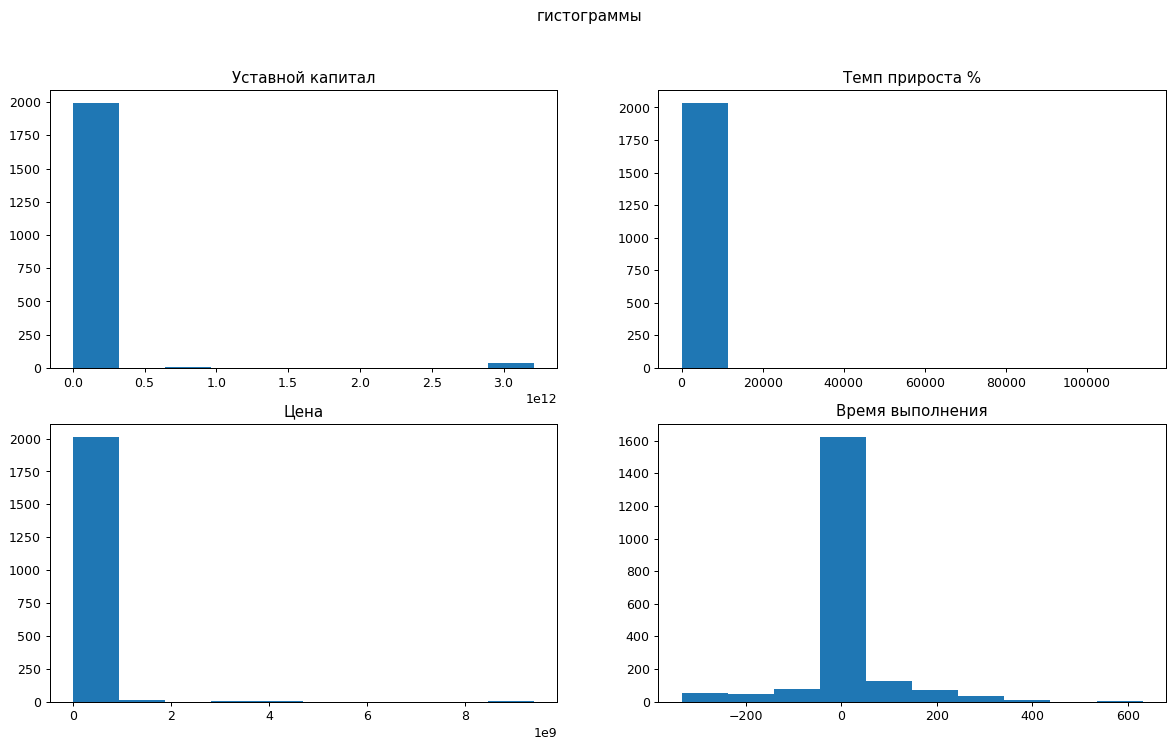

In [ ]:
fig, axs = plt.subplots(nrows= 2 , ncols= 2, figsize=(16, 9), dpi=90)

fig. suptitle('гистограммы')

axs[0, 0].hist(final_dataset['Уставной капитал'])
axs[0, 0].set_title('Уставной капитал')
axs[0, 1].hist(final_dataset['Темп прироста %'])
axs[0, 1].set_title('Темп прироста %')
axs[1, 0].hist(final_dataset['Цена'])
axs[1, 0].set_title('Цена')
axs[1, 1].hist(final_dataset['Время выполнения'])
axs[1, 1].set_title('Время выполнения');

In [ ]:
final_dataset.describe()

,Уставной капитал,Выручка,Темп прироста %,Цена,Время выполнения
count,2.035000e+03,2.052000e+03,2035.000000,2.032000e+03,2045.000000
mean,7.144983e+10,1.542873e+11,138.186167,4.482990e+07,8.016626
std,4.315239e+11,4.399752e+11,3563.490171,3.584220e+08,86.259205
min,9.000000e+03,0.000000e+00,0.300000,1.100000e-01,-334.000000
25%,4.331860e+06,3.993788e+10,8.450000,4.000000e+05,0.000000
50%,1.500000e+08,6.063971e+10,16.230000,1.443309e+06,0.000000
75%,4.142657e+09,1.139242e+11,33.550000,7.499762e+06,14.000000
max,3.212182e+12,7.593832e+12,113716.580000,9.405000e+09,631.000000


По графику с гистограммами можно заметить большие выбросы в колонках "Уставной капитал", "Цена" и "Темп прироста %", что искажает математическое ожидание, поэтому пропущенные значения в этих колонках мы заменим медианой, а в колонке "Время выполнения" - средним.

In [ ]:
final_dataset['Время выполнения'] = final_dataset['Время выполнения']\
    .fillna(final_dataset['Время выполнения'].mean())

final_dataset[['Уставной капитал', 'Цена', 'Темп прироста %']] = final_dataset[['Уставной капитал', 'Цена', 'Темп прироста %']]\
    .fillna(final_dataset[['Уставной капитал', 'Цена', 'Темп прироста %']].median())

In [ ]:
final_dataset

,ИНН поставщика,Уставной капитал,Выручка,Темп прироста %,Номер закупки,ИНН заказчика,ОКПД2,Цена,Время выполнения
0,1106014140,5.758304e+09,4.989540e+11,91.49,32110960997,1106024691,06,3.017975e+08,0.0
1,1433000147,3.682483e+09,2.617680e+11,81.11,32009437716,1435326056,19,4.775860e+08,29.0
2,1434031363,8.616038e+10,8.017448e+10,3.58,32110980912,2536038419,35,6.000000e+06,4.0
3,1434031363,8.616038e+10,8.017448e+10,3.58,32110981250,2706015700,35,8.171000e+05,0.0
4,1434031363,8.616038e+10,8.017448e+10,3.58,32111002641,2706028690,35,1.451776e+05,0.0
...,...,...,...,...,...,...,...,...,...
2047,7805018099,2.073606e+10,8.188798e+10,1.87,32009797834,6950152108,49,3.000000e+06,36.0
2048,7805018099,2.073606e+10,8.188798e+10,1.87,32009797925,6950152108,49,1.400000e+07,38.0
2049,7805018099,2.073606e+10,8.188798e+10,1.87,32111000521,6950152108,49,1.377490e+07,1.0
2050,7805018099,2.073606e+10,8.188798e+10,1.87,32111000659,6950152108,49,2.587840e+06,1.0


In [ ]:
final_dataset.isna().sum()

ИНН поставщика      0
Уставной капитал    0
Выручка             0
Темп прироста %     0
Номер закупки       0
ИНН заказчика       0
ОКПД2               0
Цена                0
Время выполнения    0
dtype: int64